<a href="https://colab.research.google.com/github/VastSea0/nasa-hackathon/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!pip3 install earthaccess

In [123]:
import earthaccess

# 1. Login
earthaccess.login()

In [153]:
results = earthaccess.search_data(
    cloud_hosted=False,
    short_name="GPM_3IMERGHH",
    temporal=("2025-05-30", "2025-10-01"), # Güncellenmiş tarih aralığı
    bounding_box=(26, 36, 45, 42)  # Türkiye: (lon_min, lat_min, lon_max, lat_max)
)

if results:
    print(f"Bulunan veri seti sayısı: {len(results)}")
    print("İlk veri seti bilgisi:")
    display(results[0]) # display kullanarak daha okunaklı çıktı alalım
else:
    print("Belirtilen kriterlere uygun veri seti bulunamadı.")

# fetch the data

Bulunan veri seti sayısı: 96
İlk veri seti bilgisi:


Collection: {'ShortName': 'GPM_3IMERGHH', 'Version': '07'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-05-30T00:00:00.000Z', 'EndingDateTime': '2025-05-30T00:29:59.999Z'}}
Size(MB): 7.972988128662109
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2025/150/3B-HHR.MS.MRG.3IMERG.20250530-S000000-E002959.0000.V07B.HDF5']

Linke tıkla ve anlaşmayı kabul et

In [154]:
nsidc_url = "https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/245/3B-HHR.MS.MRG.3IMERG.20240901-S003000-E005959.0030.V07B.HDF5"
lpcloud_url = "https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/245/3B-HHR.MS.MRG.3IMERG.20240901-S003000-E005959.0030.V07B.HDF5"

session = earthaccess.get_requests_https_session()

In [155]:
headers = {"Range": "bytes=0-100"}
r = session.get(lpcloud_url, headers=headers)
r

<Response [206]>

In [156]:
fs = earthaccess.get_fsspec_https_session()

In [157]:
with fs.open(lpcloud_url) as f:
    data = f.read(100)
data

b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff}\xb2\x82\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00OHDR'

In [158]:
%%time

import xarray as xr

files = earthaccess.open(results[0:2])

ds = xr.open_dataset(files[0], group="")
ds

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 135 ms, sys: 23.9 ms, total: 159 ms
Wall time: 4.98 s


<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    FileHeader:  DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauthority=http://dx.doi....
    FileInfo:    DataFormatVersion=7e;\nTKCodeBuildVersion=0;\nMetadataVersio...

In [161]:
import h5py
import xarray as xr # xarray'i de dahil edelim, belki açabiliriz

# Open the first dataset found in the results list using earthaccess.open()
# We will open only the first file for inspection
if results:
    print("Opening the first dataset using earthaccess.open()...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to list groups and variables using h5py
            print("\nAttempting to list groups and variables using h5py...")
            try:
                with h5py.File(file_obj, 'r') as f:
                    print("Contents of the HDF5 file (via h5py.visit):")
                    def print_groups_and_datasets(name):
                        print(name)
                    f.visit(print_groups_and_datasets)

            except Exception as h5py_e:
                print(f"h5py failed to open the file object: {h5py_e}")
                print("Attempting to open with xarray (if applicable)...")
                # If h5py fails, try opening with xarray (though likely to fail based on previous attempts)
                try:
                    ds_modis = xr.open_dataset(file_obj, engine="h5netcdf") # or other relevant engine
                    print("\nOpened with xarray. Variables:")
                    for var in ds_modis.variables:
                        print(var)
                    display(ds_modis)

                except Exception as xarray_e:
                    print(f"xarray also failed to open the file object: {xarray_e}")
                    print("Could not open the file object with either h5py or xarray.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()

        else:
            print("earthaccess.open() did not return any file objects.")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("No search results found to open.")

Opening the first dataset using earthaccess.open()...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.

Attempting to list groups and variables using h5py...
Contents of the HDF5 file (via h5py.visit):
Grid
Grid/Intermediate
Grid/Intermediate/IRinfluence
Grid/Intermediate/IRprecipitation
Grid/Intermediate/MWobservationTime
Grid/Intermediate/MWprecipSource
Grid/Intermediate/MWprecipitation
Grid/Intermediate/precipitationUncal
Grid/lat
Grid/lat_bnds
Grid/latv
Grid/lon
Grid/lon_bnds
Grid/lonv
Grid/nv
Grid/precipitation
Grid/precipitationQualityIndex
Grid/probabilityLiquidPrecipitation
Grid/randomError
Grid/time
Grid/time_bnds


In [164]:
!pip install cftime

Opening the first dataset using earthaccess.open() and xarray...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.
Attempting to open with xarray, specifying the '/Grid' group...

Inspecting 'precipitation' variable dimensions:
Dimensions: ('time', 'lon', 'lat')
Shape: (1, 3600, 1800)
Plotting spatial map for the first time step...


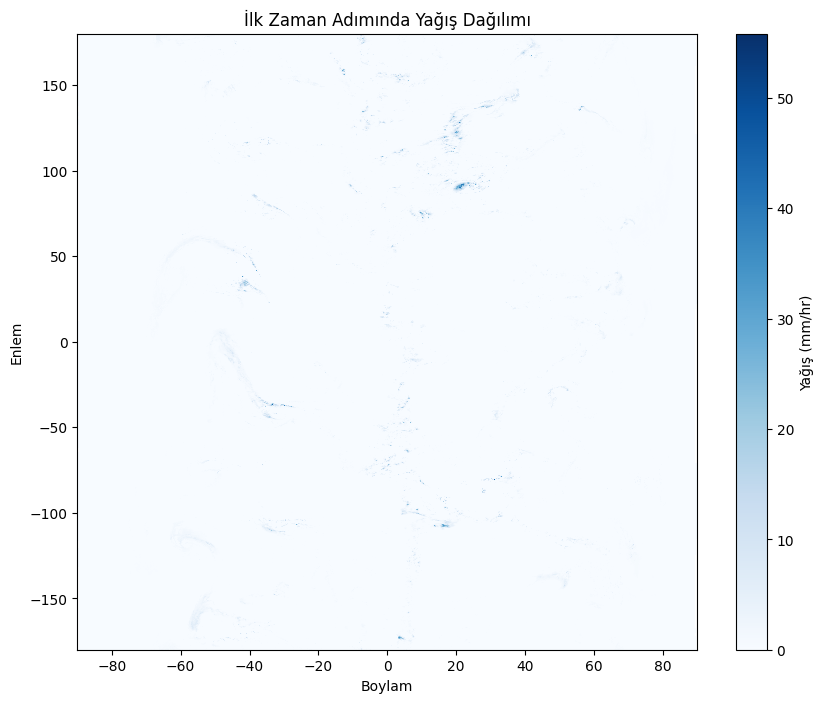

In [169]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np # numpy'ı import edelim, kullanabiliriz

# Open the first dataset found in the results list using earthaccess.open()
# Specify the group '/Grid' as the precipitation data is inside this group
if results:
    print("Opening the first dataset using earthaccess.open() and xarray...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to open with xarray, specifying the '/Grid' group
            print("Attempting to open with xarray, specifying the '/Grid' group...")
            try:
                # Ensure the file_obj is seekable if needed by xarray/engine
                # Using engine="netcdf4" is common for HDF5 files that are also NetCDF4 compliant
                # or simply rely on default engine if possible. Let's try default first.
                # Based on previous h5py output, variables are under /Grid
                ds_gpm = xr.open_dataset(file_obj, group="/Grid")


                # Check if the 'precipitation' variable exists
                if 'precipitation' in ds_gpm.variables:
                    precipitation_data = ds_gpm['precipitation']

                    print("\nInspecting 'precipitation' variable dimensions:")
                    print(f"Dimensions: {precipitation_data.dims}")
                    print(f"Shape: {precipitation_data.shape}")


                    # Check the number of time steps
                    if 'time' in precipitation_data.dims and precipitation_data.shape[precipitation_data.dims.index('time')] > 1:
                        print("Multiple time steps found, plotting mean precipitation over time...")
                        plt.figure(figsize=(12, 6))
                        # Plot the mean precipitation over the spatial dimensions
                        precipitation_data.mean(dim=('lat', 'lon')).plot()
                        plt.title('Ortalama Yağış Zaman Serisi')
                        plt.xlabel('Zaman')
                        plt.ylabel('Ortalama Yağış')
                        plt.grid(True)
                        plt.show()
                    elif 'lat' in precipitation_data.dims and 'lon' in precipitation_data.dims:
                         # If only one time step or no time dimension, plot a spatial map
                        print("Plotting spatial map for the first time step...")
                        plt.figure(figsize=(10, 8))
                        # Select the first (and likely only) time step for the spatial plot
                        precipitation_data.isel(time=0).plot(cmap='Blues', cbar_kwargs={'label': 'Yağış (mm/hr)'})
                        plt.title('İlk Zaman Adımında Yağış Dağılımı')
                        plt.xlabel('Boylam')
                        plt.ylabel('Enlem')
                        plt.show()
                    else:
                         print("Neither time nor spatial dimensions (lat, lon) found for plotting.")


                else:
                    print("'precipitation' variable not found in the /Grid group.")

            except Exception as xarray_e:
                print(f"xarray failed to open the dataset from /Grid group: {xarray_e}")
                print("Please check the group name and variable name based on the h5py output.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()


        else:
            print("No file objects were returned by earthaccess.open().")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("No search results found to open.")

In [170]:
# Assuming ds_gpm is available from the previous execution of cell
if 'ds_gpm' in locals() and ds_gpm:
    print("Spatial coverage of the visualized data:")
    if 'lat' in ds_gpm.coords and 'lon' in ds_gpm.coords:
        print(f"Latitude range: {ds_gpm['lat'].min().values} to {ds_gpm['lat'].max().values}")
        print(f"Longitude range: {ds_gpm['lon'].min().values} to {ds_gpm['lon'].max().values}")
    elif 'latitude' in ds_gpm.coords and 'longitude' in ds_gpm.coords:
         print(f"Latitude range: {ds_gpm['latitude'].min().values} to {ds_gpm['latitude'].max().values}")
         print(f"Longitude range: {ds_gpm['longitude'].min().values} to {ds_gpm['longitude'].max().values}")
    else:
        print("Latitude and Longitude coordinates not found in ds_gpm.")

else:
    print("ds_gpm variable not found. Please ensure the cell opening the dataset was executed successfully.")

Spatial coverage of the visualized data:
Latitude range: -89.94999694824219 to 89.94999694824219
Longitude range: -179.9499969482422 to 179.9499969482422


In [172]:
!pip install cartopy

Opening the first dataset using earthaccess.open() and xarray...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.
Attempting to open with xarray, specifying the '/Grid' group...

Successfully subsetted data for Türkiye bounding box.


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


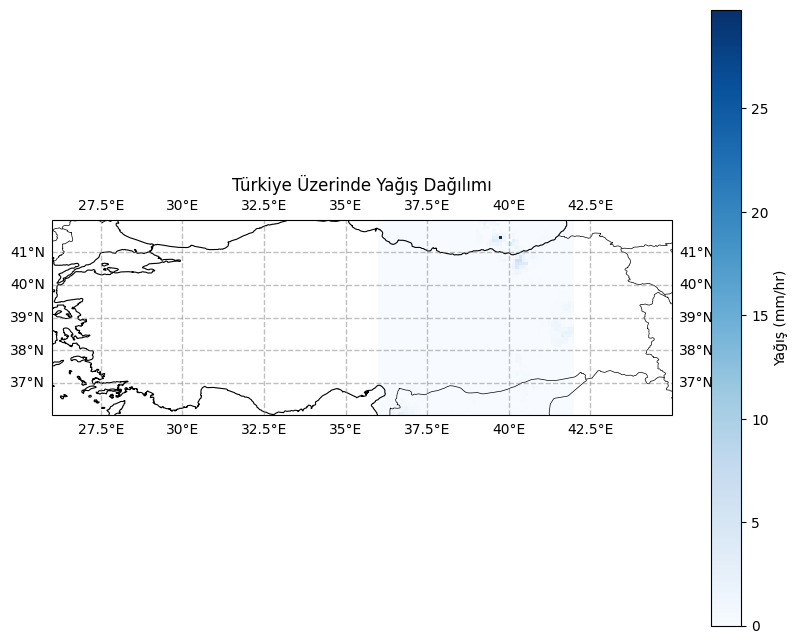

In [173]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Re-open the first dataset from results (assuming results is still available)
# Specify the group '/Grid'
if 'results' in locals() and results:
    print("Opening the first dataset using earthaccess.open() and xarray...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to open with xarray, specifying the '/Grid' group
            print("Attempting to open with xarray, specifying the '/Grid' group...")
            try:
                ds_gpm = xr.open_dataset(file_obj, group="/Grid")

                # Check if the 'precipitation' variable exists
                if 'precipitation' in ds_gpm.variables:
                    precipitation_data = ds_gpm['precipitation']

                    # Define the Türkiye bounding box again (lon_min, lat_min, lon_max, lat_max)
                    # Using the same coordinates from k57kiY_Q4AjM
                    turkey_bbox = (26, 36, 45, 42)
                    lon_min, lat_min, lon_max, lat_max = turkey_bbox

                    # Select the data within the bounding box
                    # Note: xarray's .sel() might need coordinate names ('lon', 'lat')
                    # and the order might vary depending on the dataset.
                    # Assuming the data has 'lon' and 'lat' dimensions
                    try:
                        precipitation_subset = precipitation_data.sel(
                            lon=slice(lon_min, lon_max),
                            lat=slice(lat_min, lat_max)
                        )
                        print("\nSuccessfully subsetted data for Türkiye bounding box.")

                        # Plot the subsetted data on a map
                        plt.figure(figsize=(10, 8))
                        ax = plt.axes(projection=ccrs.PlateCarree())
                        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

                        # Add coastlines and borders
                        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                        ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)

                        # Plot the precipitation data subset.
                        # Use origin='lower' if lat/lon are increasing from bottom left
                        # Use cmap='Blues' for precipitation
                        precipitation_subset.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Yağış (mm/hr)'})

                        # Add gridlines
                        ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

                        plt.title('Türkiye Üzerinde Yağış Dağılımı')
                        plt.show()

                    except Exception as subset_e:
                        print(f"Error subsetting or plotting data: {subset_e}")
                        print("Please check if coordinate names are 'lon' and 'lat' and their ranges.")


                else:
                    print("'precipitation' variable not found in the /Grid group.")

            except Exception as xarray_e:
                print(f"xarray failed to open the dataset from /Grid group: {xarray_e}")
                print("Please check the group name and variable name based on the h5py output.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()


        else:
            print("No file objects were returned by earthaccess.open().")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("results variable not found. Please run the search cell first.")